# A brief guide to FIt-SNE. Visualizing MNIST

Author: Dmitry Kobak

In [8]:
#%matplotlib notebook
%matplotlib inline

import numpy as np
import pylab as plt
import seaborn as sns
sns.set_style('ticks')

from pathlib import Path
from load_dataset import get_mnist, get_fmnist, load_wong, load_flow18

# the path should point to the FIt-SNE directory
import sys; sys.path.append('../')
from fast_tsne import fast_tsne


In [14]:
def get_dataset(dataset_id):
    """
    Given the name of a data set, load the corresponding data set.
    Parameters
    ----------
    dataset_id : String
        Number of points to be embedded in total
    Returns
    -------
    dataset_id, X, labels : String, CSR_matrix, list[]
        Name of the data set, the data, data labels
    """
    if dataset_id == "mnist":
        mnist_data_dir = Path("C:/Users/arsla/my_files/research_project/mg-emb-exps-main/mg-emb-exps-main/data/mnist")
        print("Loading MNIST data")
        return ["mnist", ] + list(get_mnist(mnist_data_dir))
    elif dataset_id == "fmnist":
        print("Loading FMNIST data")
        return ["fmnist", ] + list(get_fmnist())
    # elif dataset_id == "tasic2018":
    #     return ["tasic2018", ] + list(get_tasic2018())
    elif dataset_id == "flow18":
        flow18_path = Path("C:/Users/arsla/my_files/research_project/mg-emb-exps-main/mg-emb-exps-main/data/flow18/flow18_annotated.fcs")
        X, labels = load_flow18(flow18_path)
        return ["flow18", X, labels]
    elif dataset_id == "wong":
        wong_path = Path("C:/Users/arsla/my_files/research_project/mg-emb-exps-main/mg-emb-exps-main/data/wong")
        for f in wong_path.iterdir():
            print(f.name)

        csv_file = wong_path / "10k_parsed.csv"
        print("CSV exists:", csv_file.exists())
        print("Full path:", csv_file)

        result = load_wong(data_home= wong_path, labels_name="broad", return_colors=False)   
        if isinstance(result, tuple):
            X, labels = result
        else:
            X = result
            labels = np.zeros(X.shape[0])  # fallback: dummy labels if none are returned
        
        ## X, labels = load_wong(data_home= wong_path, labels_name="broad", return_colors=False)
        return ["wong", X, labels]
    elif dataset_id == "tsne-art-2":
        pass
    else:
        print("[perp-vs-num_samples] Dataset `{}` not supported.".format(dataset_id))

In [15]:
# # Load MNIST data
# from sklearn.datasets import fetch_openml
# mnist = fetch_openml('mnist_784')
# X = mnist.data
# y = mnist.target.astype('int')
# print(X.shape)

# # Do PCA and keep 50 dimensions
# X = X - X.mean(axis=0)
# U, s, V = np.linalg.svd(X, full_matrices=False)
# X50 = np.dot(U, np.diag(s))[:,:50]

# # 10 nice colors
# col = np.array(['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99',
#                 '#e31a1c','#fdbf6f','#ff7f00','#cab2d6','#6a3d9a'])


# Step 1: Load data
dataset_name, X, y = get_dataset("mnist")

# Step 2: Preprocess (mean center + PCA to 50 dims)
X = X - X.mean(axis=0)
U, s, V = np.linalg.svd(X, full_matrices=False)
X50 = np.dot(U, np.diag(s))[:, :50]

Loading MNIST data


In [16]:
# Running t-SNE on the full PCA-reduced MNIST in the default way 
# This uses perplexity 30 and PCA initialization.
# It runs for 750 iterations with learning rate N/12.

# %time Z = fast_tsne(X50)

# plt.figure(figsize=(4,4))
# plt.axis('equal')
# plt.scatter(Z[:,0], Z[:,1], c=col[y], s=2, edgecolors='none')
# sns.despine()
# plt.tight_layout()



# Step 3: Run fast_tsne
Z = fast_tsne(X50)

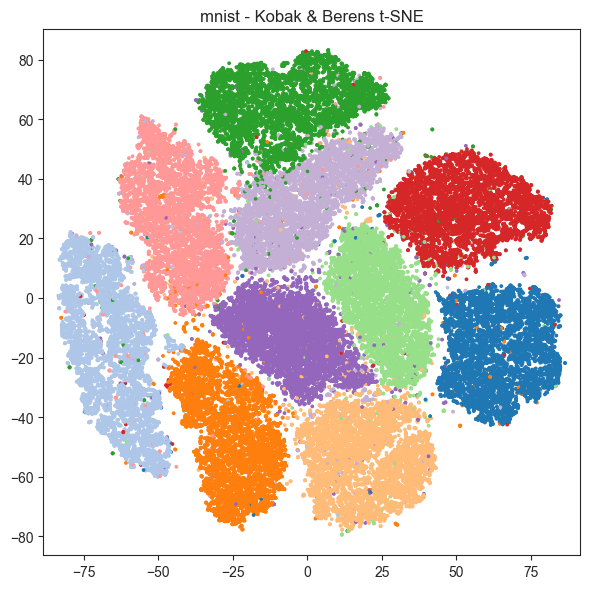

In [18]:
# Step 4: Plot
# unique_labels = np.unique(y)
# palette = sns.color_palette("tab10", n_colors=len(unique_labels))

# n_classes = len(np.unique(y))
# palette = sns.color_palette("tab20", n_colors=n_classes)  # 'tab20' supports up to 20

# Normalize labels to 0-based indices
unique_labels, y_normalized = np.unique(y, return_inverse=True)

# Safe palette size
palette = sns.color_palette("tab20", n_colors=len(unique_labels))

# Map normalized labels to colors
colors = [palette[i] for i in y_normalized]

plt.figure(figsize=(6,6))
plt.axis("equal")
# plt.scatter(Z[:, 0], Z[:, 1], c=[palette[int(label)] for label in y], s=3)
plt.scatter(Z[:, 0], Z[:, 1], c=colors, s=3)
plt.title("mnist - Kobak & Berens t-SNE")
plt.tight_layout()

## Using random initialization
Note that this is generally a bad idea. See here for discussion: https://www.nature.com/articles/s41467-019-13056-x.

In [4]:
%time Z1 = fast_tsne(X50, initialization='random', seed=1)
%time Z2 = fast_tsne(X50, initialization='random', seed=2)

CPU times: total: 93.8 ms
Wall time: 41 s
CPU times: total: 62.5 ms
Wall time: 40.5 s


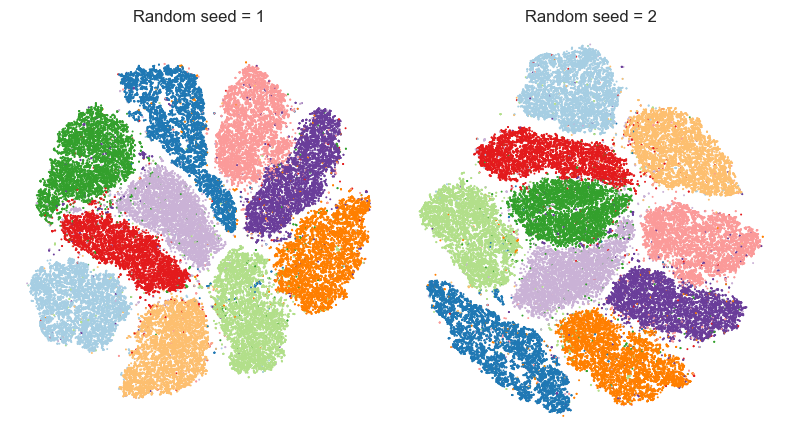

In [5]:
plt.figure(figsize=(8, 4.5))
for i, (Z,title) in enumerate(zip([Z1,Z2], ['Random seed = 1', 'Random seed = 2'])):
    plt.subplot(1,2,i+1)
    plt.axis('equal')
    plt.scatter(Z[:,0], Z[:,1], c=col[y], s=2, edgecolors='none')
    plt.xticks([])
    plt.yticks([])
    plt.title(title)

sns.despine(left=True, bottom=True)
plt.tight_layout()

The above uses learning rate N/12. If one uses low learning rate, e.g. 200 which used to be the default value, then clusters sometimes get split into multiple subclusters.

In [14]:
%time Z1 = fast_tsne(X50, initialization='random', seed=1, learning_rate=200)
%time Z2 = fast_tsne(X50, initialization='random', seed=2, learning_rate=200)

CPU times: user 88 ms, sys: 44 ms, total: 132 ms
Wall time: 43.7 s
CPU times: user 84 ms, sys: 32 ms, total: 116 ms
Wall time: 44.6 s


<IPython.core.display.Javascript object>


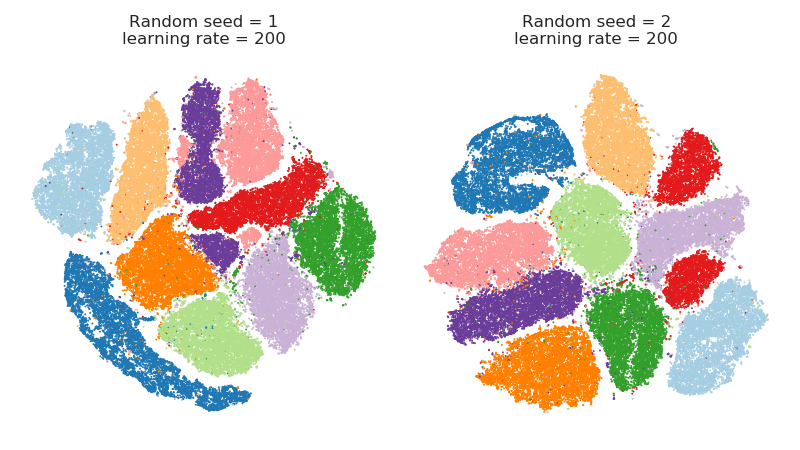

In [15]:
plt.figure(figsize=(8, 4.5))
for i,(Z,title) in enumerate(zip([Z1,Z2], ['Random seed = 1\nlearning rate = 200', 
                                           'Random seed = 2\nlearning rate = 200'])):
    plt.subplot(1,2,i+1)
    plt.axis('equal')
    plt.scatter(Z[:,0], Z[:,1], c=col[y], s=2, edgecolors='none')
    plt.xticks([])
    plt.yticks([])
    plt.title(title)

sns.despine(left=True, bottom=True)
plt.tight_layout()

## Changing perplexity

In [8]:
%time Z1 = fast_tsne(X50, perplexity=3)
%time Z2 = fast_tsne(X50, perplexity=300)

CPU times: user 1.55 s, sys: 768 ms, total: 2.32 s
Wall time: 1min 10s
CPU times: user 1.69 s, sys: 1.26 s, total: 2.95 s
Wall time: 4min 38s


<IPython.core.display.Javascript object>


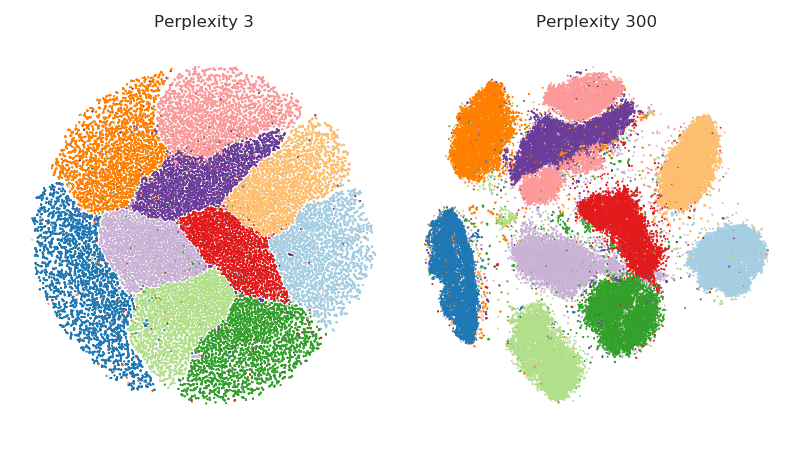

In [9]:
plt.figure(figsize=(8, 4.5))
for i,(Z,title) in enumerate(zip([Z1,Z2], ['Perplexity 3', 'Perplexity 300'])):
    plt.subplot(1,2,i+1)
    plt.axis('equal')
    plt.scatter(Z[:,0], Z[:,1], c=col[y], s=2, edgecolors='none')
    plt.xticks([])
    plt.yticks([])
    plt.title(title)

sns.despine(left=True, bottom=True)
plt.tight_layout()

## Exaggeration
Exaggeration is applied after the early exaggeration phase is over. By default, early exaggeration lasts 250 iterations, with coefficient 12.

In [10]:
%time Z1 = fast_tsne(X50, late_exag_coeff=2)
%time Z2 = fast_tsne(X50, late_exag_coeff=4)

CPU times: user 1.78 s, sys: 1.07 s, total: 2.86 s
Wall time: 46.9 s
CPU times: user 1.66 s, sys: 956 ms, total: 2.61 s
Wall time: 43.5 s


<IPython.core.display.Javascript object>


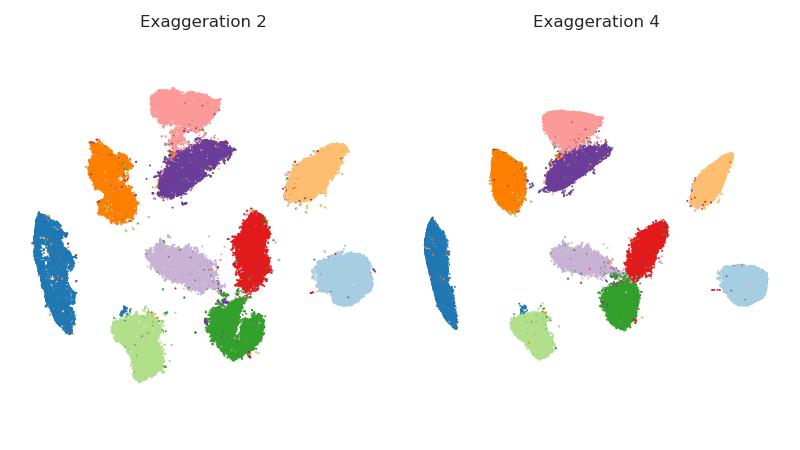

In [11]:
plt.figure(figsize=(8, 4.5))

for i,(Z,title) in enumerate(zip([Z1,Z2], ['Exaggeration 2', 'Exaggeration 4'])):
    plt.subplot(1,2,i+1)
    plt.axis('equal')
    plt.scatter(Z[:,0], Z[:,1], c=col[y], s=2, edgecolors='none')
    plt.xticks([])
    plt.yticks([])
    plt.title(title)

sns.despine(left=True, bottom=True)
plt.tight_layout()

## Making the kernel more/less heavy-tailed
The default Cauchy kernel corresponds to `df=1`. Large `df` corresponds to the Gaussian kernel.

See https://ecmlpkdd2019.org/downloads/paper/327.pdf

In [12]:
%time Z1 = fast_tsne(X50, df=100)
%time Z2 = fast_tsne(X50, df=.5)

CPU times: user 1.49 s, sys: 848 ms, total: 2.34 s
Wall time: 53.2 s
CPU times: user 1.76 s, sys: 1.2 s, total: 2.96 s
Wall time: 1min 9s


<IPython.core.display.Javascript object>


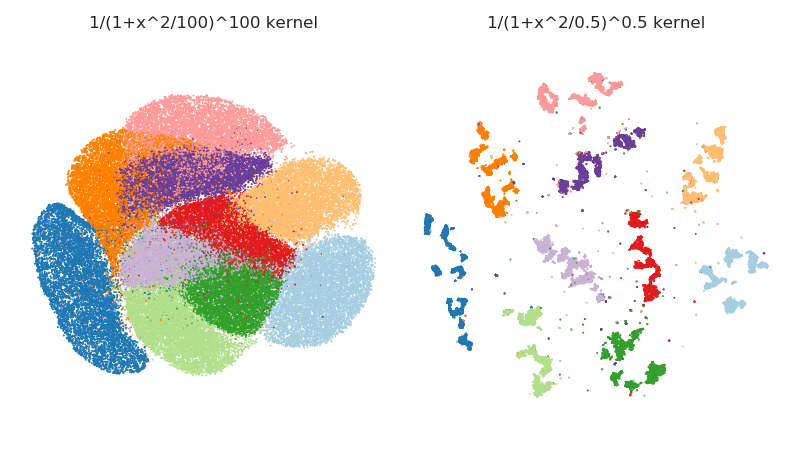

In [13]:
plt.figure(figsize=(8, 4.5))

for i,(Z,title) in enumerate(zip([Z1,Z2], ['1/(1+x^2/100)^100 kernel',
                                           '1/(1+x^2/0.5)^0.5 kernel'])):
    plt.subplot(1,2,i+1)
    plt.axis('equal')
    plt.scatter(Z[:,0], Z[:,1], c=col[y], s=2, edgecolors='none')
    plt.xticks([])
    plt.yticks([])
    plt.title(title)

sns.despine(left=True, bottom=True)
plt.tight_layout()

## 1-dimensional embedding

In [3]:
%time Z1 = fast_tsne(X50)
%time Z2 = fast_tsne(X50, map_dims=1)

CPU times: user 1.86 s, sys: 884 ms, total: 2.74 s
Wall time: 1min 15s
CPU times: user 1.29 s, sys: 776 ms, total: 2.07 s
Wall time: 24.7 s


<IPython.core.display.Javascript object>


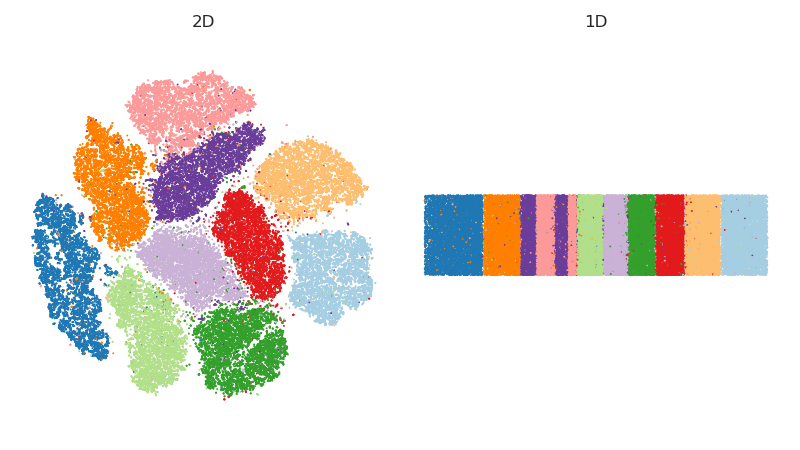

In [4]:
plt.figure(figsize=(8,4.5))
plt.subplot(121)
plt.axis('equal')
plt.scatter(Z1[:,0], Z1[:,1], c=col[y], s=2, edgecolors='none')
plt.xticks([])
plt.yticks([])
plt.title('2D')

plt.subplot(122)
plt.scatter(Z2[:,0], np.random.uniform(size=Z2.shape[0]), c=col[y], s=2, edgecolors='none')
plt.ylim([-2,3])
plt.xticks([])
plt.yticks([])
plt.title('1D')

sns.despine(left=True, bottom=True)
plt.tight_layout()

## 1D embeddings with different output kernels

In [5]:
%%time

dfs = [100, 10, 1, .5, .2, .1, .05]
Zs = []
for df in dfs:
    Z = fast_tsne(X50, map_dims=1, df=df)
    Zs.append(Z)

CPU times: user 8.89 s, sys: 4.68 s, total: 13.6 s
Wall time: 3min 25s


<IPython.core.display.Javascript object>


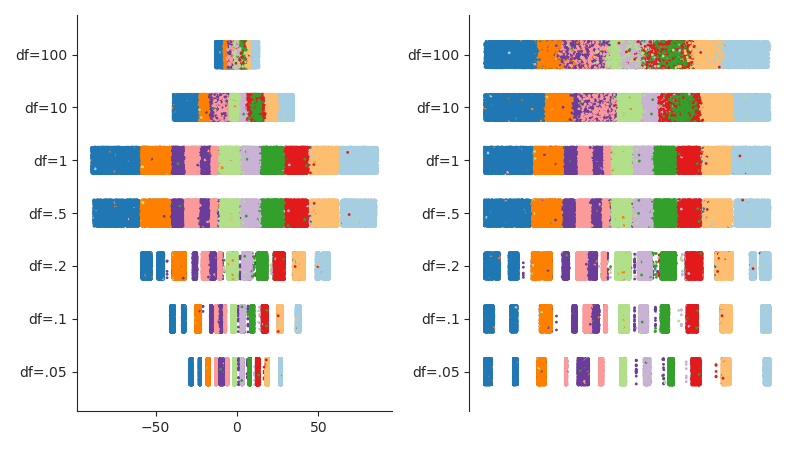

In [6]:
plt.figure(figsize=(8,4.5))
ax1 = plt.subplot(121)
for i,(df,Z) in enumerate(zip(dfs,Zs)):
    plt.scatter(Z[:,0], np.random.uniform(size=Z.shape[0])/2-i, c=col[y], s=1)
plt.ylim([-6.5,1])
plt.yticks(np.array([-6,-5,-4,-3,-2,-1,0])+.25, ['df=.05','df=.1','df=.2','df=.5','df=1','df=10','df=100'])

ax2 = plt.subplot(122)
for i,(df,Z) in enumerate(zip(dfs,Zs)):
    plt.scatter((Z[:,0]-np.min(Z))/(np.max(Z)-np.min(Z)), np.random.uniform(size=Z.shape[0])/2-i, c=col[y], s=1)
plt.ylim([-6.5,1])
plt.yticks(np.array([-6,-5,-4,-3,-2,-1,0])+.25, ['df=.05','df=.1','df=.2','df=.5','df=1','df=10','df=100'])
plt.xticks([])

sns.despine(ax=ax1)
sns.despine(ax=ax2, bottom=True)

plt.tight_layout()

## Fixed sigma instead of perplexity

In [7]:
%time Z1 = fast_tsne(X50)
%time Z2 = fast_tsne(X50, sigma=1e+6, K=10)

CPU times: user 1.68 s, sys: 696 ms, total: 2.37 s
Wall time: 1min 14s
CPU times: user 1.48 s, sys: 788 ms, total: 2.26 s
Wall time: 1min 2s


<IPython.core.display.Javascript object>


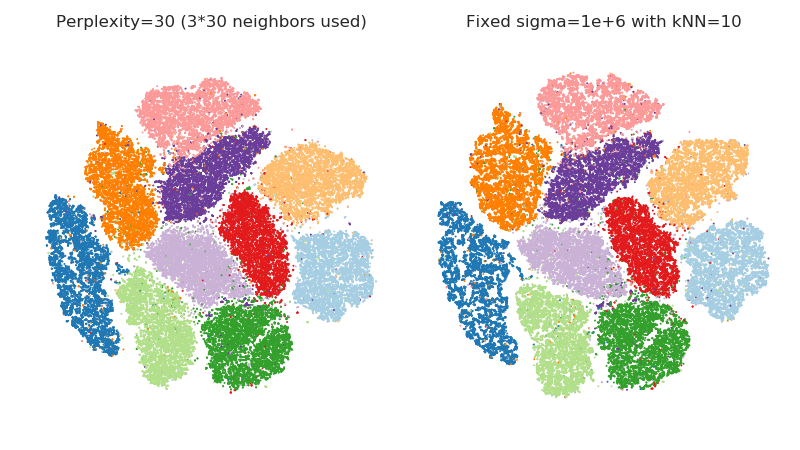

In [8]:
plt.figure(figsize=(8, 4.5))

for i,(Z,title) in enumerate(zip([Z1,Z2], ['Perplexity=30 (3*30 neighbors used)',
                                           'Fixed sigma=1e+6 with kNN=10'])):
    plt.subplot(1,2,i+1)
    plt.axis('equal')
    plt.scatter(Z[:,0], Z[:,1], c=col[y], s=2, edgecolors='none')
    plt.xticks([])
    plt.yticks([])
    plt.title(title)

sns.despine(left=True, bottom=True)
plt.tight_layout()

## Perplexity combination
Is not useful for MNIST, but can be useful in other cases, see https://www.nature.com/articles/s41467-019-13056-x.

In [9]:
%time Z1 = fast_tsne(X50)
%time Z2 = fast_tsne(X50, perplexity_list=[3,30,300])

CPU times: user 1.68 s, sys: 656 ms, total: 2.34 s
Wall time: 1min 15s
CPU times: user 1.59 s, sys: 920 ms, total: 2.51 s
Wall time: 5min 10s


<IPython.core.display.Javascript object>


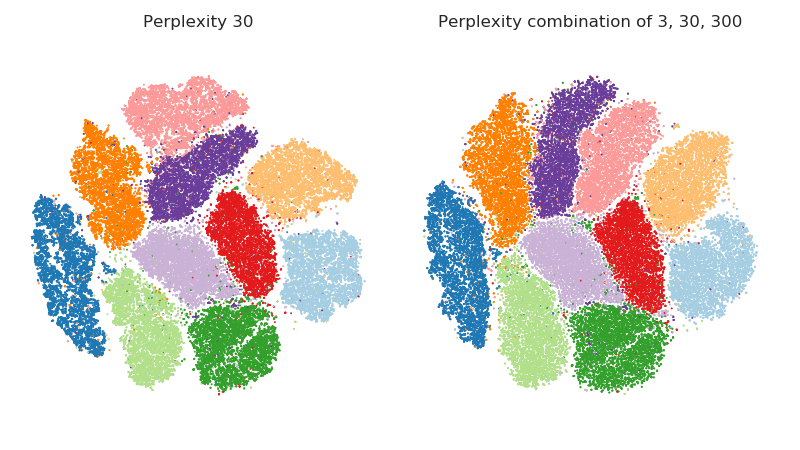

In [10]:
plt.figure(figsize=(8, 4.5))

for i,(Z,title) in enumerate(zip([Z1,Z2], ['Perplexity 30',
                                           'Perplexity combination of 3, 30, 300'])):
    plt.subplot(1,2,i+1)
    plt.axis('equal')
    plt.scatter(Z[:,0], Z[:,1], c=col[y], s=2, edgecolors='none')
    plt.xticks([])
    plt.yticks([])
    plt.title(title)

sns.despine(left=True, bottom=True)
plt.tight_layout()

## VP tree vs ANNOY for kNN search

In [11]:
%time Z1 = fast_tsne(X50)
%time Z2 = fast_tsne(X50, knn_algo='vp-tree')

CPU times: user 1.77 s, sys: 764 ms, total: 2.53 s
Wall time: 1min 16s
CPU times: user 1.65 s, sys: 916 ms, total: 2.57 s
Wall time: 2min 12s


<IPython.core.display.Javascript object>


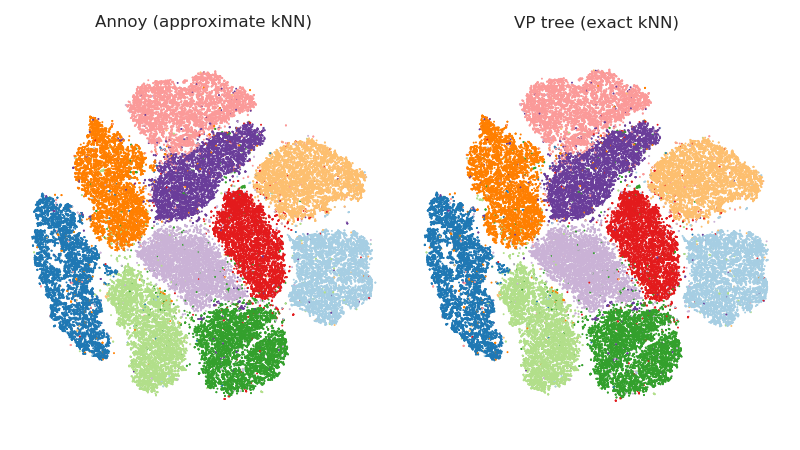

In [12]:
plt.figure(figsize=(8, 4.5))

for i,(Z,title) in enumerate(zip([Z1,Z2], ['Annoy (approximate kNN)',
                                           'VP tree (exact kNN)'])):
    plt.subplot(1,2,i+1)
    plt.axis('equal')
    plt.scatter(Z[:,0], Z[:,1], c=col[y], s=2, edgecolors='none')
    plt.xticks([])
    plt.yticks([])
    plt.title(title)

sns.despine(left=True, bottom=True)
plt.tight_layout()

## Barnes-Hut vs FFT to approximate repulsive forces during gradient descent 
Using a subsampled dataset here, to speed up Barnes-Hut.

In [3]:
# Subsampling 

np.random.seed(42)
ind10k = np.random.choice(X.shape[0], 10000, replace=False)

%time Z1 = fast_tsne(X50[ind10k,:])
%time Z2 = fast_tsne(X50[ind10k,:], nbody_algo='Barnes-Hut')

CPU times: user 584 ms, sys: 20 ms, total: 604 ms
Wall time: 28.1 s
CPU times: user 560 ms, sys: 24 ms, total: 584 ms
Wall time: 36.1 s


<IPython.core.display.Javascript object>


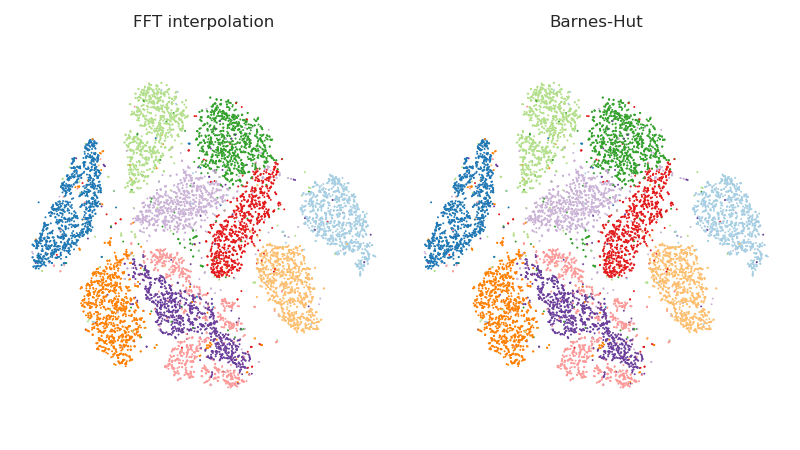

In [4]:
plt.figure(figsize=(8, 4.5))

for i,(Z,title) in enumerate(zip([Z2,Z2], ['FFT interpolation',
                                           'Barnes-Hut'])):
    plt.subplot(1,2,i+1)
    plt.axis('equal')
    plt.scatter(Z[:,0], Z[:,1], c=col[y[ind10k]], s=2, edgecolors='none')
    plt.xticks([])
    plt.yticks([])
    plt.title(title)

sns.despine(left=True, bottom=True)
plt.tight_layout()

## Exact t-SNE

In [15]:
# Subsampling 

np.random.seed(42)
ind2k = np.random.choice(X.shape[0], 2000, replace=False)

%time Z1 = fast_tsne(X50[ind2k,:])
%time Z2 = fast_tsne(X50[ind2k,:], theta=0)

CPU times: user 20 ms, sys: 76 ms, total: 96 ms
Wall time: 9.39 s
CPU times: user 16 ms, sys: 36 ms, total: 52 ms
Wall time: 1min 3s


<IPython.core.display.Javascript object>


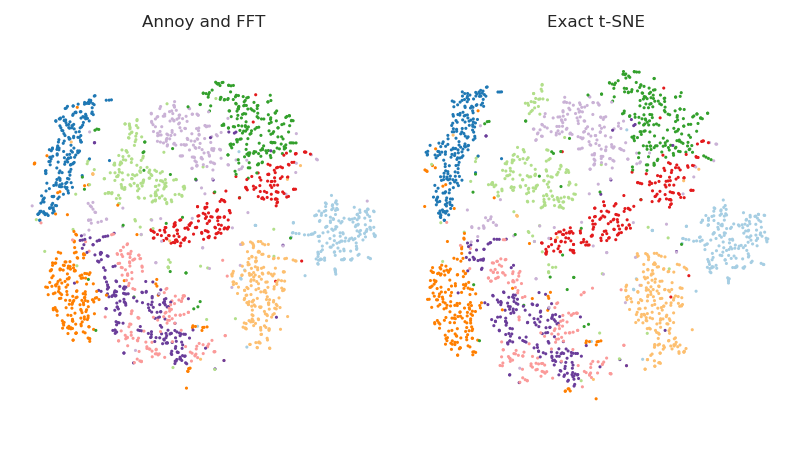

In [16]:
plt.figure(figsize=(8, 4.5))

for i,(Z,title) in enumerate(zip([Z1,Z2], ['Annoy and FFT', 'Exact t-SNE'])):
    plt.subplot(1,2,i+1)
    plt.axis('equal')
    plt.scatter(Z[:,0], Z[:,1], c=col[y[ind2k]], s=5, edgecolors='none')
    plt.xticks([])
    plt.yticks([])
    plt.title(title)

sns.despine(left=True, bottom=True)
plt.tight_layout()

## Loading and saving input similarities

In [17]:
%time Z1 = fast_tsne(X50, load_affinities = 'save')
%time Z2 = fast_tsne(X50, load_affinities = 'load')

CPU times: user 1.64 s, sys: 796 ms, total: 2.43 s
Wall time: 1min 17s
CPU times: user 1.52 s, sys: 856 ms, total: 2.38 s
Wall time: 1min 5s


<IPython.core.display.Javascript object>


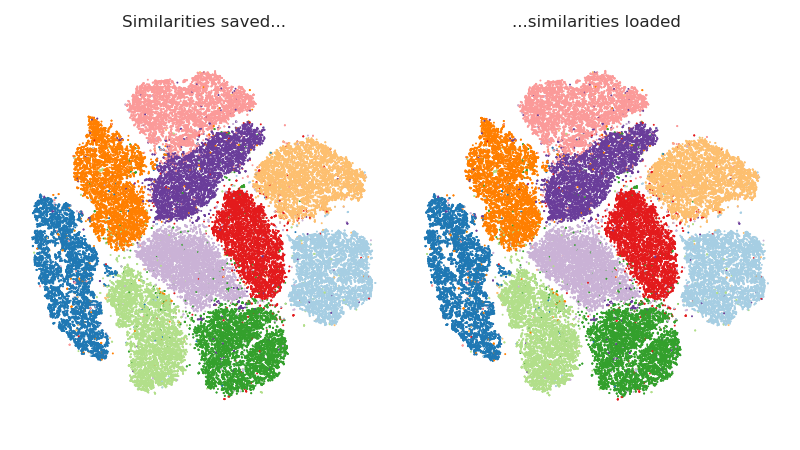

In [18]:
plt.figure(figsize=(8, 4.5))

for i,(Z,title) in enumerate(zip([Z1,Z2], ['Similarities saved...', '...similarities loaded'])):
    plt.subplot(1,2,i+1)
    plt.axis('equal')
    plt.scatter(Z[:,0], Z[:,1], c=col[y], s=2, edgecolors='none')
    plt.xticks([])
    plt.yticks([])
    plt.title(title)

sns.despine(left=True, bottom=True)
plt.tight_layout()

In [19]:
# And now for the exact t-SNE

%time Z1 = fast_tsne(X50[ind2k,:], theta=0, load_affinities = 'save')
%time Z2 = fast_tsne(X50[ind2k,:], theta=0, load_affinities = 'load')

CPU times: user 36 ms, sys: 24 ms, total: 60 ms
Wall time: 1min 4s
CPU times: user 20 ms, sys: 40 ms, total: 60 ms
Wall time: 1min 1s


<IPython.core.display.Javascript object>


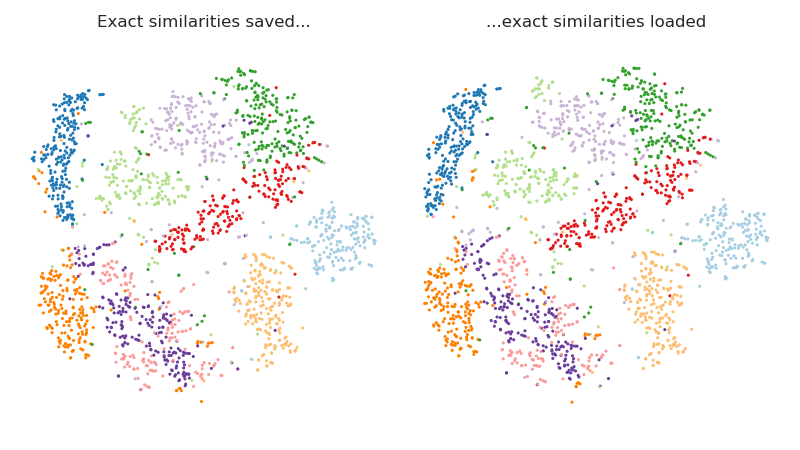

In [20]:
plt.figure(figsize=(8, 4.5))

for i,(Z,title) in enumerate(zip([Z1,Z2], ['Exact similarities saved...', '...exact similarities loaded'])):
    plt.subplot(1,2,i+1)
    plt.axis('equal')
    plt.scatter(Z[:,0], Z[:,1], c=col[y[ind2k]], s=5, edgecolors='none')
    plt.xticks([])
    plt.yticks([])
    plt.title(title)

sns.despine(left=True, bottom=True)
plt.tight_layout()